# Comparison of AQS Monitor Concentrations to CMAQ HR2DAY Output

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** needham.michael@epa.gov

**Description:** Builds on the previous example (__[Example 2](./02_hr2day_output_analysis_example.ipynb)__) to demonstrate the following funcionality:
* Download AQS monitor data using the __[pyRSIG](https://barronh.github.io/pyrsig/)__ package
* Compare AQS data to CMAQ output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyrsig import RsigApi
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np

import shapely
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from geopy.distance import geodesic
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


## 1. Data I/O

<div class="alert alert-block alert-info">
This tutorial uses a file <code>./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc</code> which was generated in the <b><a href="./A1_concat_files.ipynb">concat files</a></b> auxiliary example. Note that the output file has already been formatted using <code>src.utils.cmaq.get_cmaq_metadata</code> as part of that auxiliary example.
</div>

In [3]:
from src.utils.cmaq import get_cmaq_projection
from src.utils.matplotlib import discrete_colorbar
from src.utils.cartopy import default_map, map_tiles

In [4]:
file = Path("./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc")

dset = xr.open_dataset(file)
proj = get_cmaq_projection(dset)

# Get the daterange from the netcdf file to use with pyRSIG
bdate = pd.to_datetime(dset.time[0].data)
edate = pd.to_datetime(dset.time[-1].data)

print(f"Date Range: {bdate} to {edate}")

Date Range: 2022-04-30 00:00:00 to 2022-08-05 00:00:00


In [5]:
print(f"Total size of the dataset: {dset.nbytes / 1e6} MB")

Total size of the dataset: 19.758744 MB


## 2. Data download with pyRSIG

See the __[Auxiliary Example 2](./A2_aqs_download_pyrsig.ipynb)__ for a thorough example of this process. Here, use the same values from that example for the pyRSIG request. If that Auxiliary example has been run, this cell should pull the cached data; if not, will download the full dataset from the RSIG server

In [6]:
# x0, x1, y0, y1 coordinates of the bounding box in longitude / latitude

x0 = -98
x1 = -85
y0 = 36
y1 = 44

bbox = [x0, y0, x1, y1]

key = "aqs.ozone_daily_8hour_maximum"

# Initialize the RsigApi object
rsigapi = RsigApi(
    bbox=bbox,
    bdate=bdate,
    edate=edate,
    workdir="./tutorial_data/",  # <--- Cached data will be stored here
)

# Perform the request
aqs_mda8o3 = rsigapi.to_dataframe(key=key)

# Also, drop any NaN values
aqs_mda8o3 = aqs_mda8o3[~np.isnan(aqs_mda8o3["ozone_daily_8hour_maximum(ppb)"])]

print(f"Number of Rows: {len(aqs_mda8o3)}")
aqs_mda8o3.head()

Using cached: ./tutorial_data//aqs.ozone_daily_8hour_maximum_2022-04-30T000000Z_2022-08-05T000000Z.csv.gz
Number of Rows: 17370


Timestamp(UTC)  LONGITUDE(deg)  LATITUDE(deg)  STATION(-)  \
0  2022-04-30T00:00:00-0000        -94.1168        36.1797    51430005   
1  2022-04-30T00:00:00-0000        -94.1674        36.0117    51430006   
2  2022-04-30T00:00:00-0000        -91.3359        39.9154   170010007   
3  2022-04-30T00:00:00-0000        -88.1885        40.2449   170190007   
4  2022-04-30T00:00:00-0000        -88.3725        40.0528   170191001   

   ozone_daily_8hour_maximum(ppb)  \
0                            45.0   
1                            47.0   
2                            52.0   
3                            43.0   
4                            41.0   

                                      SITE_NAME  
0                                    Springdale  
1                                  Fayetteville  
2                                        Quincy  
3                                    Thomasboro  
4                                     Bondville

## 3. Select Desired Location for Model/Observation Comparison


### 3.A Coordinate Transformation
As in __[Example 2](./02_hr2day_output_analysis_example.ipynb)__, we will index the CMAQ output in its native Lambert coordinates. The procedure is to identify a location of interest in lat/lon, convert to Lambert x/y, then index the dataset using x/y

In [7]:
# Specify the coordinates in lat/lon, then transform to the desired lambert
# coordinate system using geopandas

lon = -90.25
lat = 38.875

# Specify the desired point in the original (lat/lon) coordinate system
pt_latlon = gpd.GeoDataFrame(
    geometry=[shapely.Point(lon, lat)],
    crs=ccrs.PlateCarree(),  # <- native crs is lat/lon
)

# Transform from the original crs to the lambert projection of the data
pt_lambert = pt_latlon.to_crs(proj)


print("Native Coordinates")
print("=" * 40)
print(pt_latlon)
print("\n")


print("Transformed Coordinates")
print("=" * 40)
print(pt_lambert)

Native Coordinates
                 geometry
0  POINT (-90.250 38.875)


Transformed Coordinates
                          geometry
0  POINT (3534025.643 2669401.822)


### 3.B Show Monitor Locations

Monitor data exists for multiple timesteps, but for this simple map comparing the location of the data selection to the monitors, plot the set of unique latitude/longitude pairs

In [8]:
# add a new column to aqs_mda8o3 which is the combined lat/lon pair so that we
# can find all AQS monitors included within our dataset. This is robust to
# situations where some monitors do not operate at all timestamps within our
# data range

# Need to create the lon, lat pair as a tuple otherwise the .unique() call will
# fail... then convert to a np.array
aqs_mda8o3["COORDS"] = [
    (lon, lat, station)
    for lon, lat, station in zip(
        aqs_mda8o3["LONGITUDE(deg)"],
        aqs_mda8o3["LATITUDE(deg)"],
        aqs_mda8o3["STATION(-)"].astype(str),
    )
]

unique_coords = aqs_mda8o3["COORDS"].unique()
unique_coords = np.array([list(x) for x in unique_coords])

stations = gpd.GeoDataFrame(
    index=[str(x) for x in unique_coords[:, 2]],
    geometry=[
        shapely.Point(lon, lat)
        for lon, lat in zip(unique_coords[:, 0], unique_coords[:, 1])
    ],
)

stations.crs = ccrs.PlateCarree()

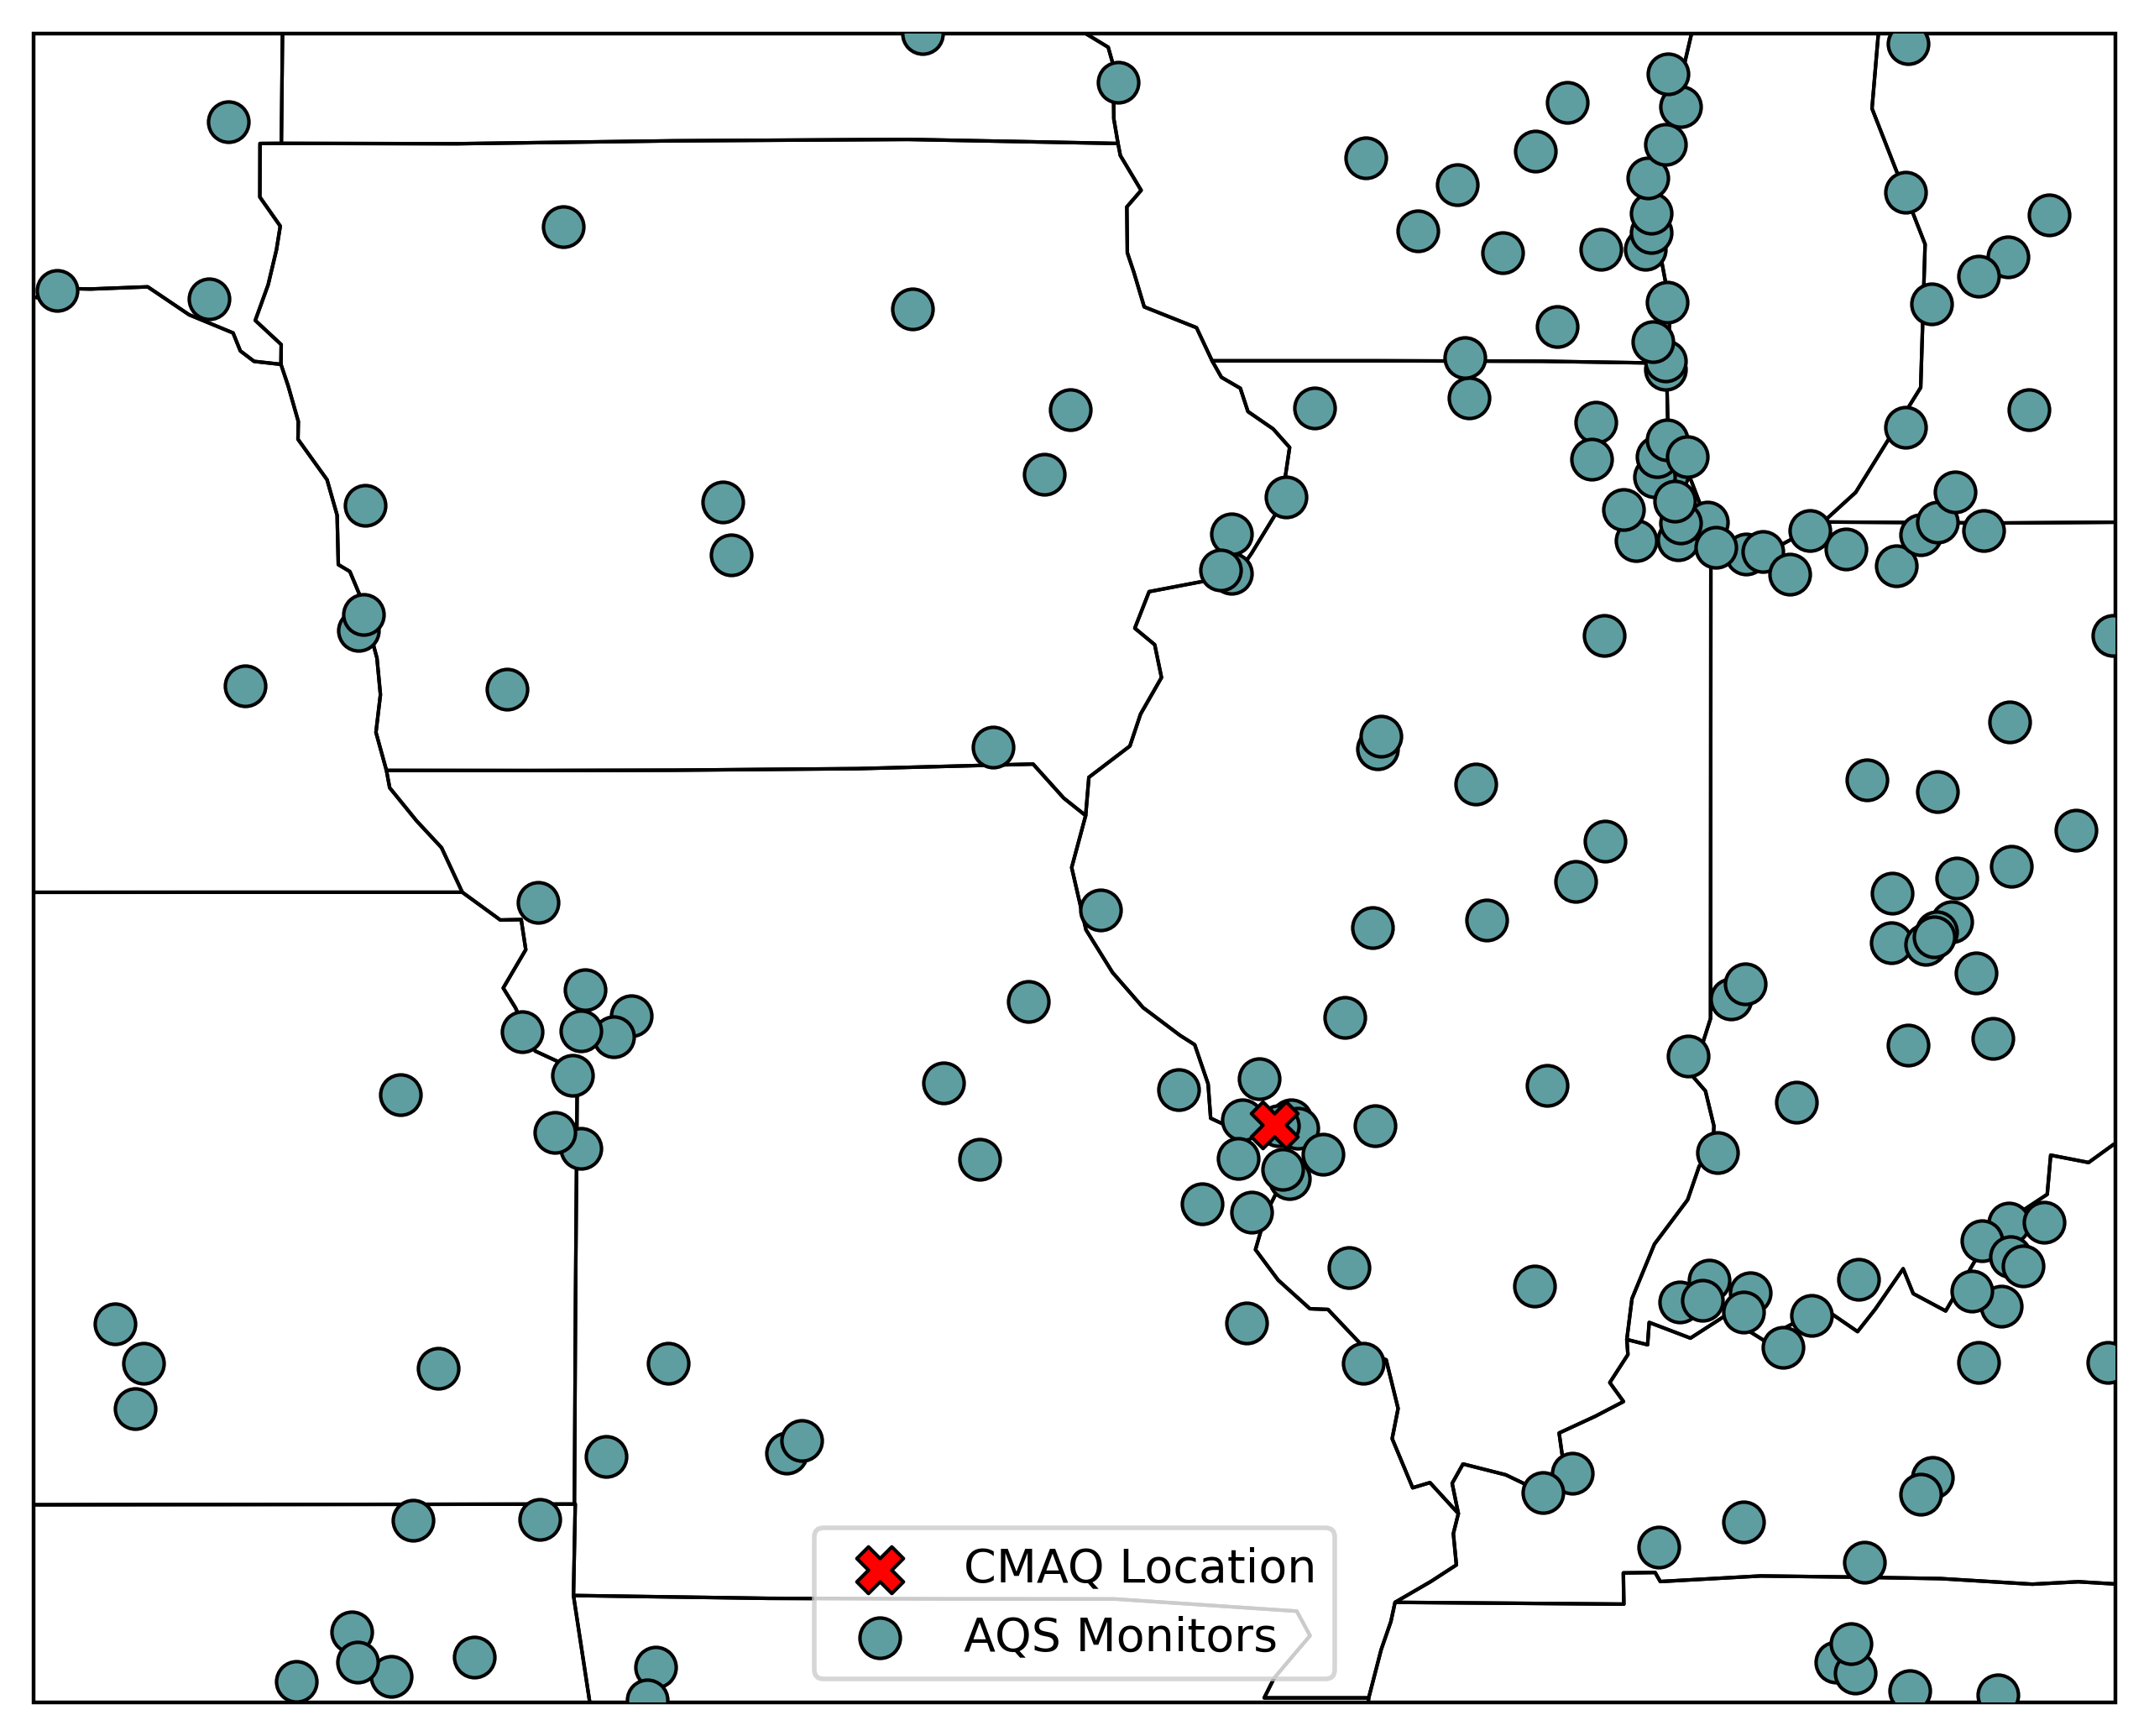

In [9]:
fig_proj = ccrs.Mercator()
# fig_proj = proj

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=fig_proj), dpi=400)

# Calling pt_lambert.geometry.x.iloc[0] is ugly, but there appears to be a bug
# where directly calling pt_lambert.plots(ax=ax, ...) prevents the image from
# including the open street map image tiles, so using this workaround for now
ax.scatter(
    pt_lambert.geometry.x.iloc[0],
    pt_lambert.geometry.y.iloc[0],
    color="r",
    ec="k",
    marker="X",
    lw=0.75,
    label="CMAQ Location",
    s=100,
    transform=pt_lambert.crs,
    zorder=11,
)

ax.scatter(
    stations.geometry.x,
    stations.geometry.y,
    color="cadetblue",
    ec="k",
    lw=0.75,
    label="AQS Monitors",
    s=75,
    transform=stations.crs,
    zorder=10,
)

default_map(ax, extent=[x0, x1, y0, y1])
ax.legend()

## 4. Index AQS Data

Here is a first example of model/observation comparison. We have selected a specific lat/lon pair and would like to compare the CMAQ output at that point to nearby AQS monitors. 

### 4.A Find Nearby Monitors

In [10]:
# First calculate the distance between each monitor and the desired cmaq
# location using geopy.distance.geodesic

nearby_stations = gpd.GeoDataFrame(geometry=stations.geometry, crs=stations.crs)

nearby_stations["Distance (miles)"] = stations.geometry.apply(
    lambda pt: geodesic(
        (pt.y, pt.x), (pt_latlon.geometry.y.iloc[0], pt_latlon.geometry.x.iloc[0])
    ).miles
)

# Then, sort the stations by increasing distance
nearby_stations = nearby_stations.sort_values("Distance (miles)")

nearby_stations.head()

geometry  Distance (miles)
291831002  POINT (-90.227 38.873)          1.278863
171190120  POINT (-90.146 38.901)          5.879771
171193007  POINT (-90.106 38.861)          7.833256
291831004  POINT (-90.449 38.899)         10.870464
295100085  POINT (-90.198 38.656)         15.335128

### 4.B Make the plot

Also, this is an opportunity to highlight the different __[Matplotlib style sheets](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)__ which allow for easy changing of default parameters

In [11]:
plt.style.use("ggplot")

In [12]:
cmaq_pt = dset.O3.sel(
    x=pt_lambert.geometry.x.iloc[0], y=pt_lambert.geometry.y.iloc[0], method="nearest"
)

n_monitors = 6

(10.0, 90.0)

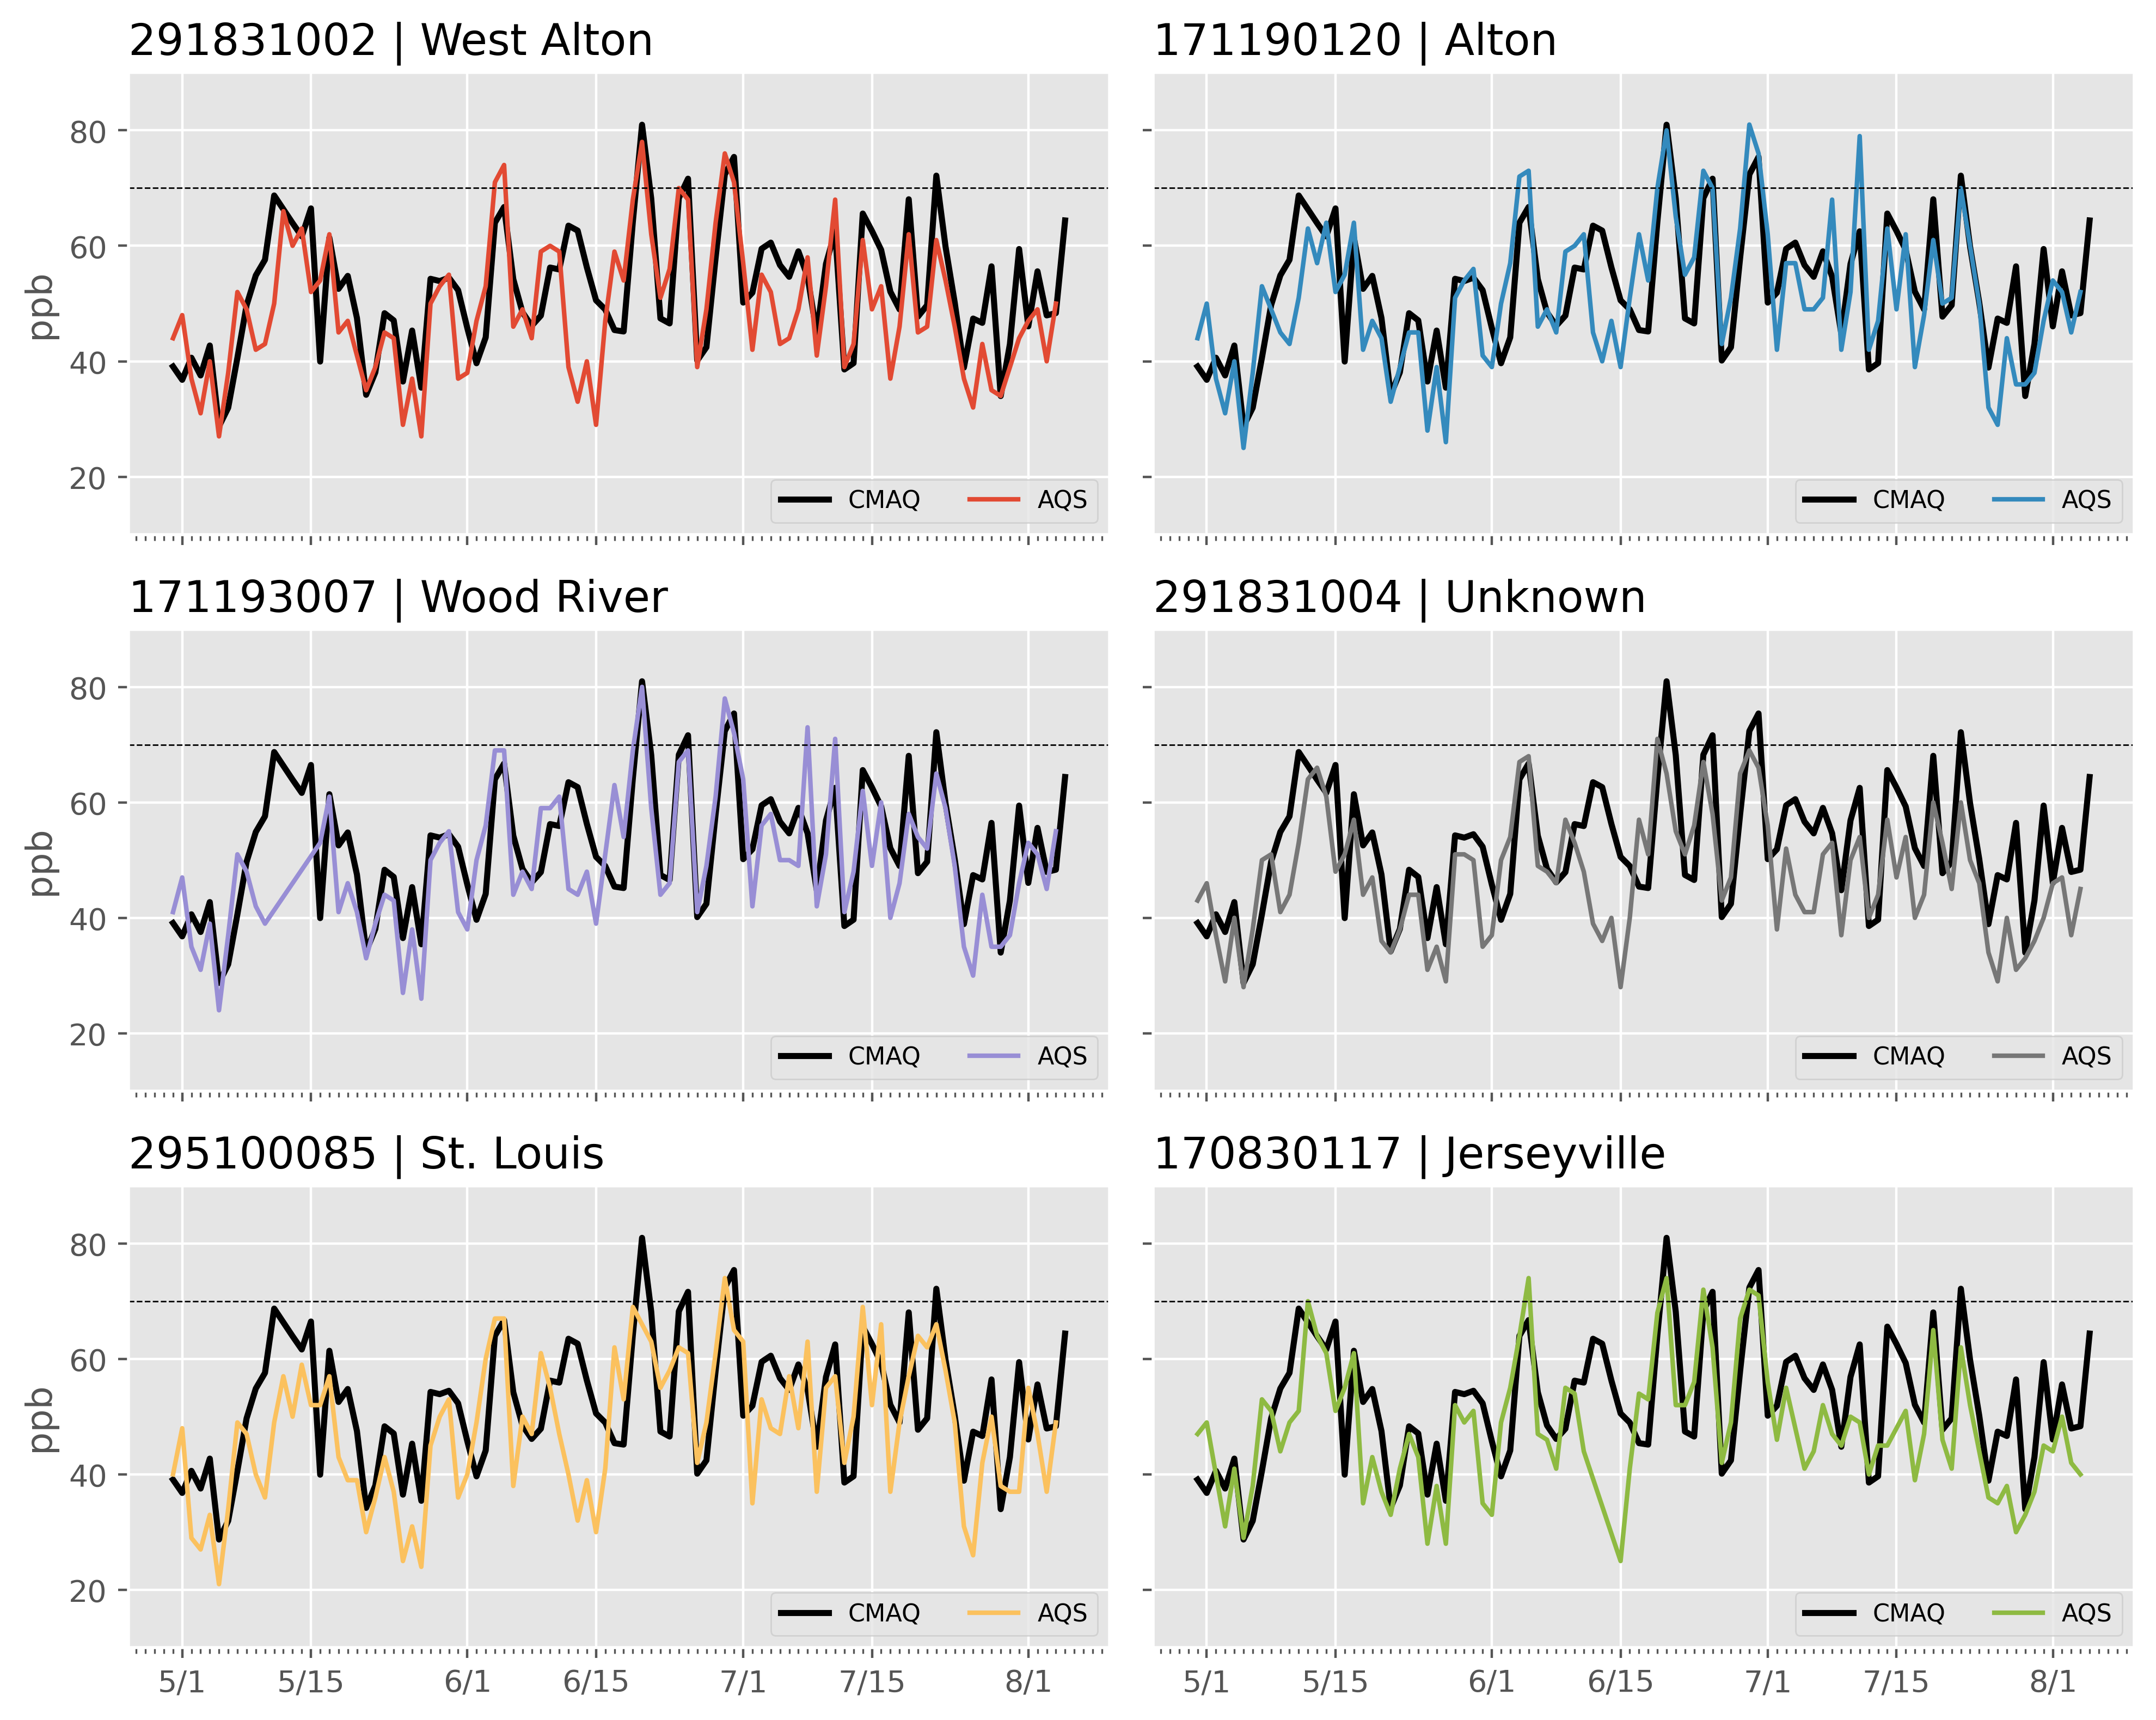

In [13]:
fig, axs = plt.subplots(
    nrows=3, ncols=2, figsize=(10, 8), dpi=400, sharex=True, sharey=True, layout="tight"
)

axs = axs.flatten()

# Get the colors from the current style sheet for explicit selection within loop
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

ix = 0
for station, ax in zip(nearby_stations.index[:n_monitors], axs):

    ax.plot(cmaq_pt.time, cmaq_pt * 1e3, color="k", lw=2, label="CMAQ")

    tmp = aqs_mda8o3[aqs_mda8o3["STATION(-)"] == int(station)]
    tmp.index = pd.to_datetime(tmp["Timestamp(UTC)"])

    ax.plot(
        tmp.index,
        tmp["ozone_daily_8hour_maximum(ppb)"],
        label="AQS",
        color=colors[ix],
    )

    ax.set_title(f"{station} | {tmp['SITE_NAME'].iloc[0].strip()}", loc="left")

    ax.legend(fontsize=8, loc="lower right", ncol=2)
    ax.axhline(70, color="k", lw=0.5, ls="--")
    if ix % 2 == 0:
        ax.set_ylabel("ppb")

    ix += 1

ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=[1, 15]))
ax.xaxis.set_minor_locator(mpl.dates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%-m/%-d"))

ax.set_ylim(10, 90)

We can also make a quick map showing the location of these monitors. Since this map will be so zommed in, can add open street map image tiles to help with referencing. Uses __[cartopy.io.img_tiles.OSM](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.io.img_tiles.OSM.html)__

CPU times: user 43 ms, sys: 3.05 ms, total: 46.1 ms
Wall time: 82 ms


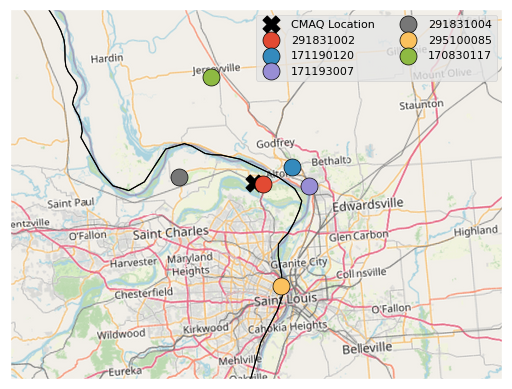

In [14]:
%%time

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

ax.scatter(
    pt_lambert.geometry.x.iloc[0],
    pt_lambert.geometry.y.iloc[0],
    color="k",
    ec="k",
    marker="X",
    lw=0.75,
    label="CMAQ Location",
    s=150,
    transform=pt_lambert.crs,
    zorder=11,
)

for ix, pt in enumerate(nearby_stations[:n_monitors].iterrows()):
    ax.scatter(
        pt[1].geometry.x,
        pt[1].geometry.y,
        label=pt[0],
        s=150,
        zorder=11,
        ec="k",
        transform=stations.crs,
    )

default_map(ax, extent=[-90.875, -89.625, 38.5, 39.2], scale="10m")
map_tiles(ax, zoom=9)
ax.legend(ncols=2, fontsize=8)

## 5. Get nearest CMAQ data to AQS sites

Another use-case is start from a list of AQS sites and find the CMAQ gridcell nearest to each site for comparison. We will find interesting sites by looking at the correlation coefficient between all monitors and and their nearest gridcell. This looping takes a bit of time, so add a status bar with __[TQDM](https://github.com/tqdm/tqdm)__

In [15]:
# First, need to pair each monitor with its corresponding gridcell
paired_data = {}

for station in tqdm(stations.iterrows(), total=len(stations)):
    # Convert the coordinates to the CMAQ projection
    coords = gpd.GeoDataFrame(
        geometry=[station[1].geometry], crs=ccrs.PlateCarree()
    ).to_crs(proj)

    aqs_data = aqs_mda8o3[aqs_mda8o3["STATION(-)"] == float(station[0])]
    aqs_data.set_index("Timestamp(UTC)", inplace=True)
    aqs_data.index = pd.to_datetime(aqs_data.index)

    # Find the nearest grid cell to the monitor
    cmaq_data = dset.O3.sel(
        x=coords.geometry.x.iloc[0], y=coords.geometry.y.iloc[0], method="nearest"
    ).to_pandas()
    cmaq_data.index = cmaq_data.index.tz_localize(tz="utc")

    # Merge the two timeseries
    data = pd.DataFrame(columns=["AQS", "CMAQ"])

    for timestep in cmaq_data.index:
        cmaq_datapoint = cmaq_data.loc[timestep] * 1e3

        try:
            aqs_datapoint = aqs_data.loc[timestep]["ozone_daily_8hour_maximum(ppb)"]
        except KeyError:
            aqs_datapoint = np.nan

        data.loc[timestep] = [aqs_datapoint, cmaq_datapoint]

    paired_data[station[0]] = data

100%|██████████| 183/183 [00:19<00:00,  9.51it/s]


In [16]:
# Now that monitors are paired, calculate r and R2 (After dropping NaNs)
stations_rval = gpd.GeoDataFrame(index=stations.index, geometry=stations.geometry)

r_vals = []
for station in stations_rval.index:
    data = paired_data[station].dropna(how="any")

    r_vals.append(np.corrcoef(data["AQS"], data["CMAQ"])[0][1])

stations_rval["r"] = r_vals
stations_rval["R2"] = stations_rval["r"] ** 2
stations_rval = stations_rval.sort_values("R2", ascending=False)

stations_rval.head()

geometry         r        R2
261390005  POINT (-85.853 42.894)  0.849548  0.721732
551170006  POINT (-87.716 43.667)  0.832061  0.692326
261210039  POINT (-86.311 43.278)  0.824239  0.679371
260050003  POINT (-86.149 42.768)  0.820031  0.672450
550390006  POINT (-88.422 43.687)  0.815244  0.664623

Now that we have a $R^2$ value for each monitor, we can display these on a map to see if there is any spatial pattern to the monitor-model (dis)agreement.

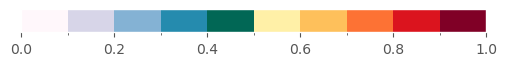

In [17]:
# Resample the colorbars so that cmap1 has twice as many colors as cmap2. This
# fraction will make it easy to align the limits so that the break between the
# two colorbars occurs right at the deisred 0.070 ppb threshold
cmap1 = mpl.colormaps["PuBuGn"]
cmap2 = mpl.colormaps["YlOrRd"]

# Generate a list of colors from the two existing cmaps in the desired order,
# from which we will generate the new colormap
clist = []
for n in range(cmap1.N):
    rgb = cmap1(n)
    clist.append(rgb)

for n in range(cmap2.N):
    rgb = cmap2(n)
    clist.append(rgb)

# Generate the new colorbar based on the colorbar list
cmap = ListedColormap(clist, name="ozone")

smap = discrete_colorbar(vmin=0, vmax=1, dlev=0.1, cmap=cmap, display_colorbar=True)

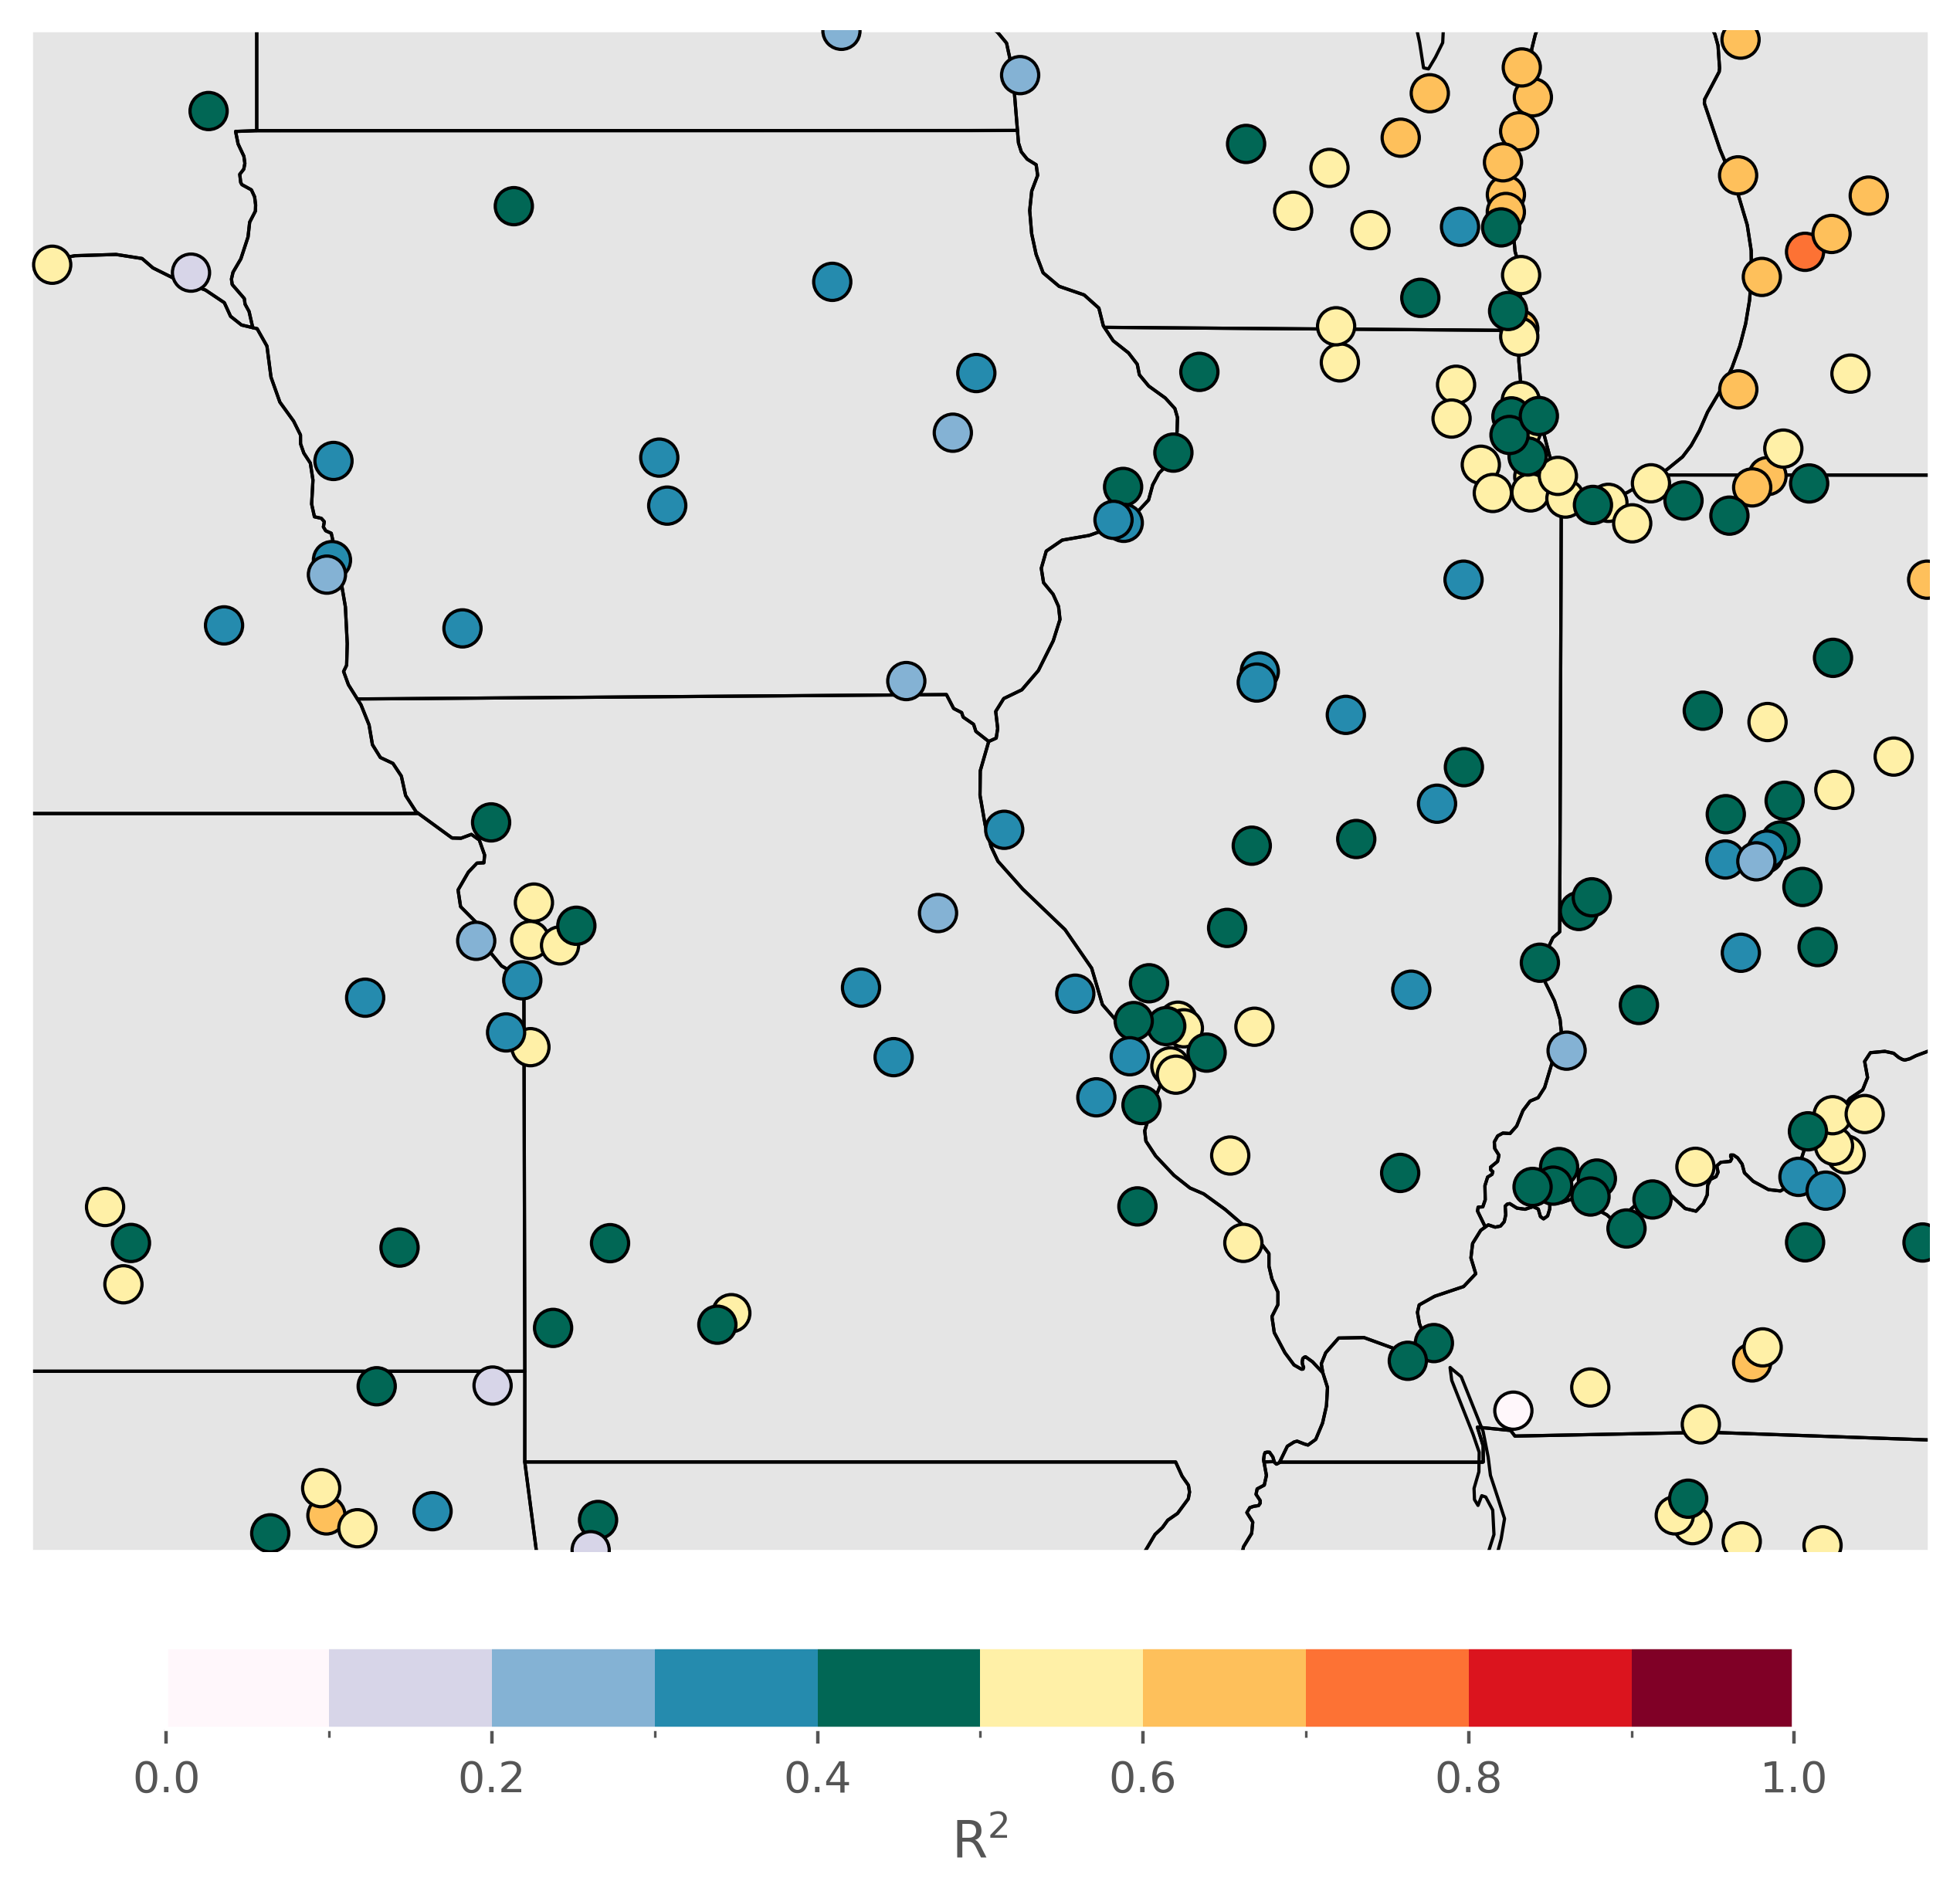

In [18]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=fig_proj), dpi=400)

ax.scatter(
    stations_rval.geometry.x,
    stations_rval.geometry.y,
    c=stations_rval["R2"],
    ec="k",
    lw=0.75,
    label="AQS Monitors",
    s=75,
    cmap=smap.cmap,
    norm=smap.norm,
    zorder=10,
    transform=stations_rval.crs,
)

default_map(ax, extent=[x0, x1, y0, y1], scale="50m")

cbar = fig.colorbar(smap, ax=ax, orientation="horizontal", pad=0.05, shrink=0.85)
cbar.set_label("R$^2$")

We can also show timeseries of the sites where the agreement with the CMAQ output was the best (or the worst)

(20.0, 105.0)

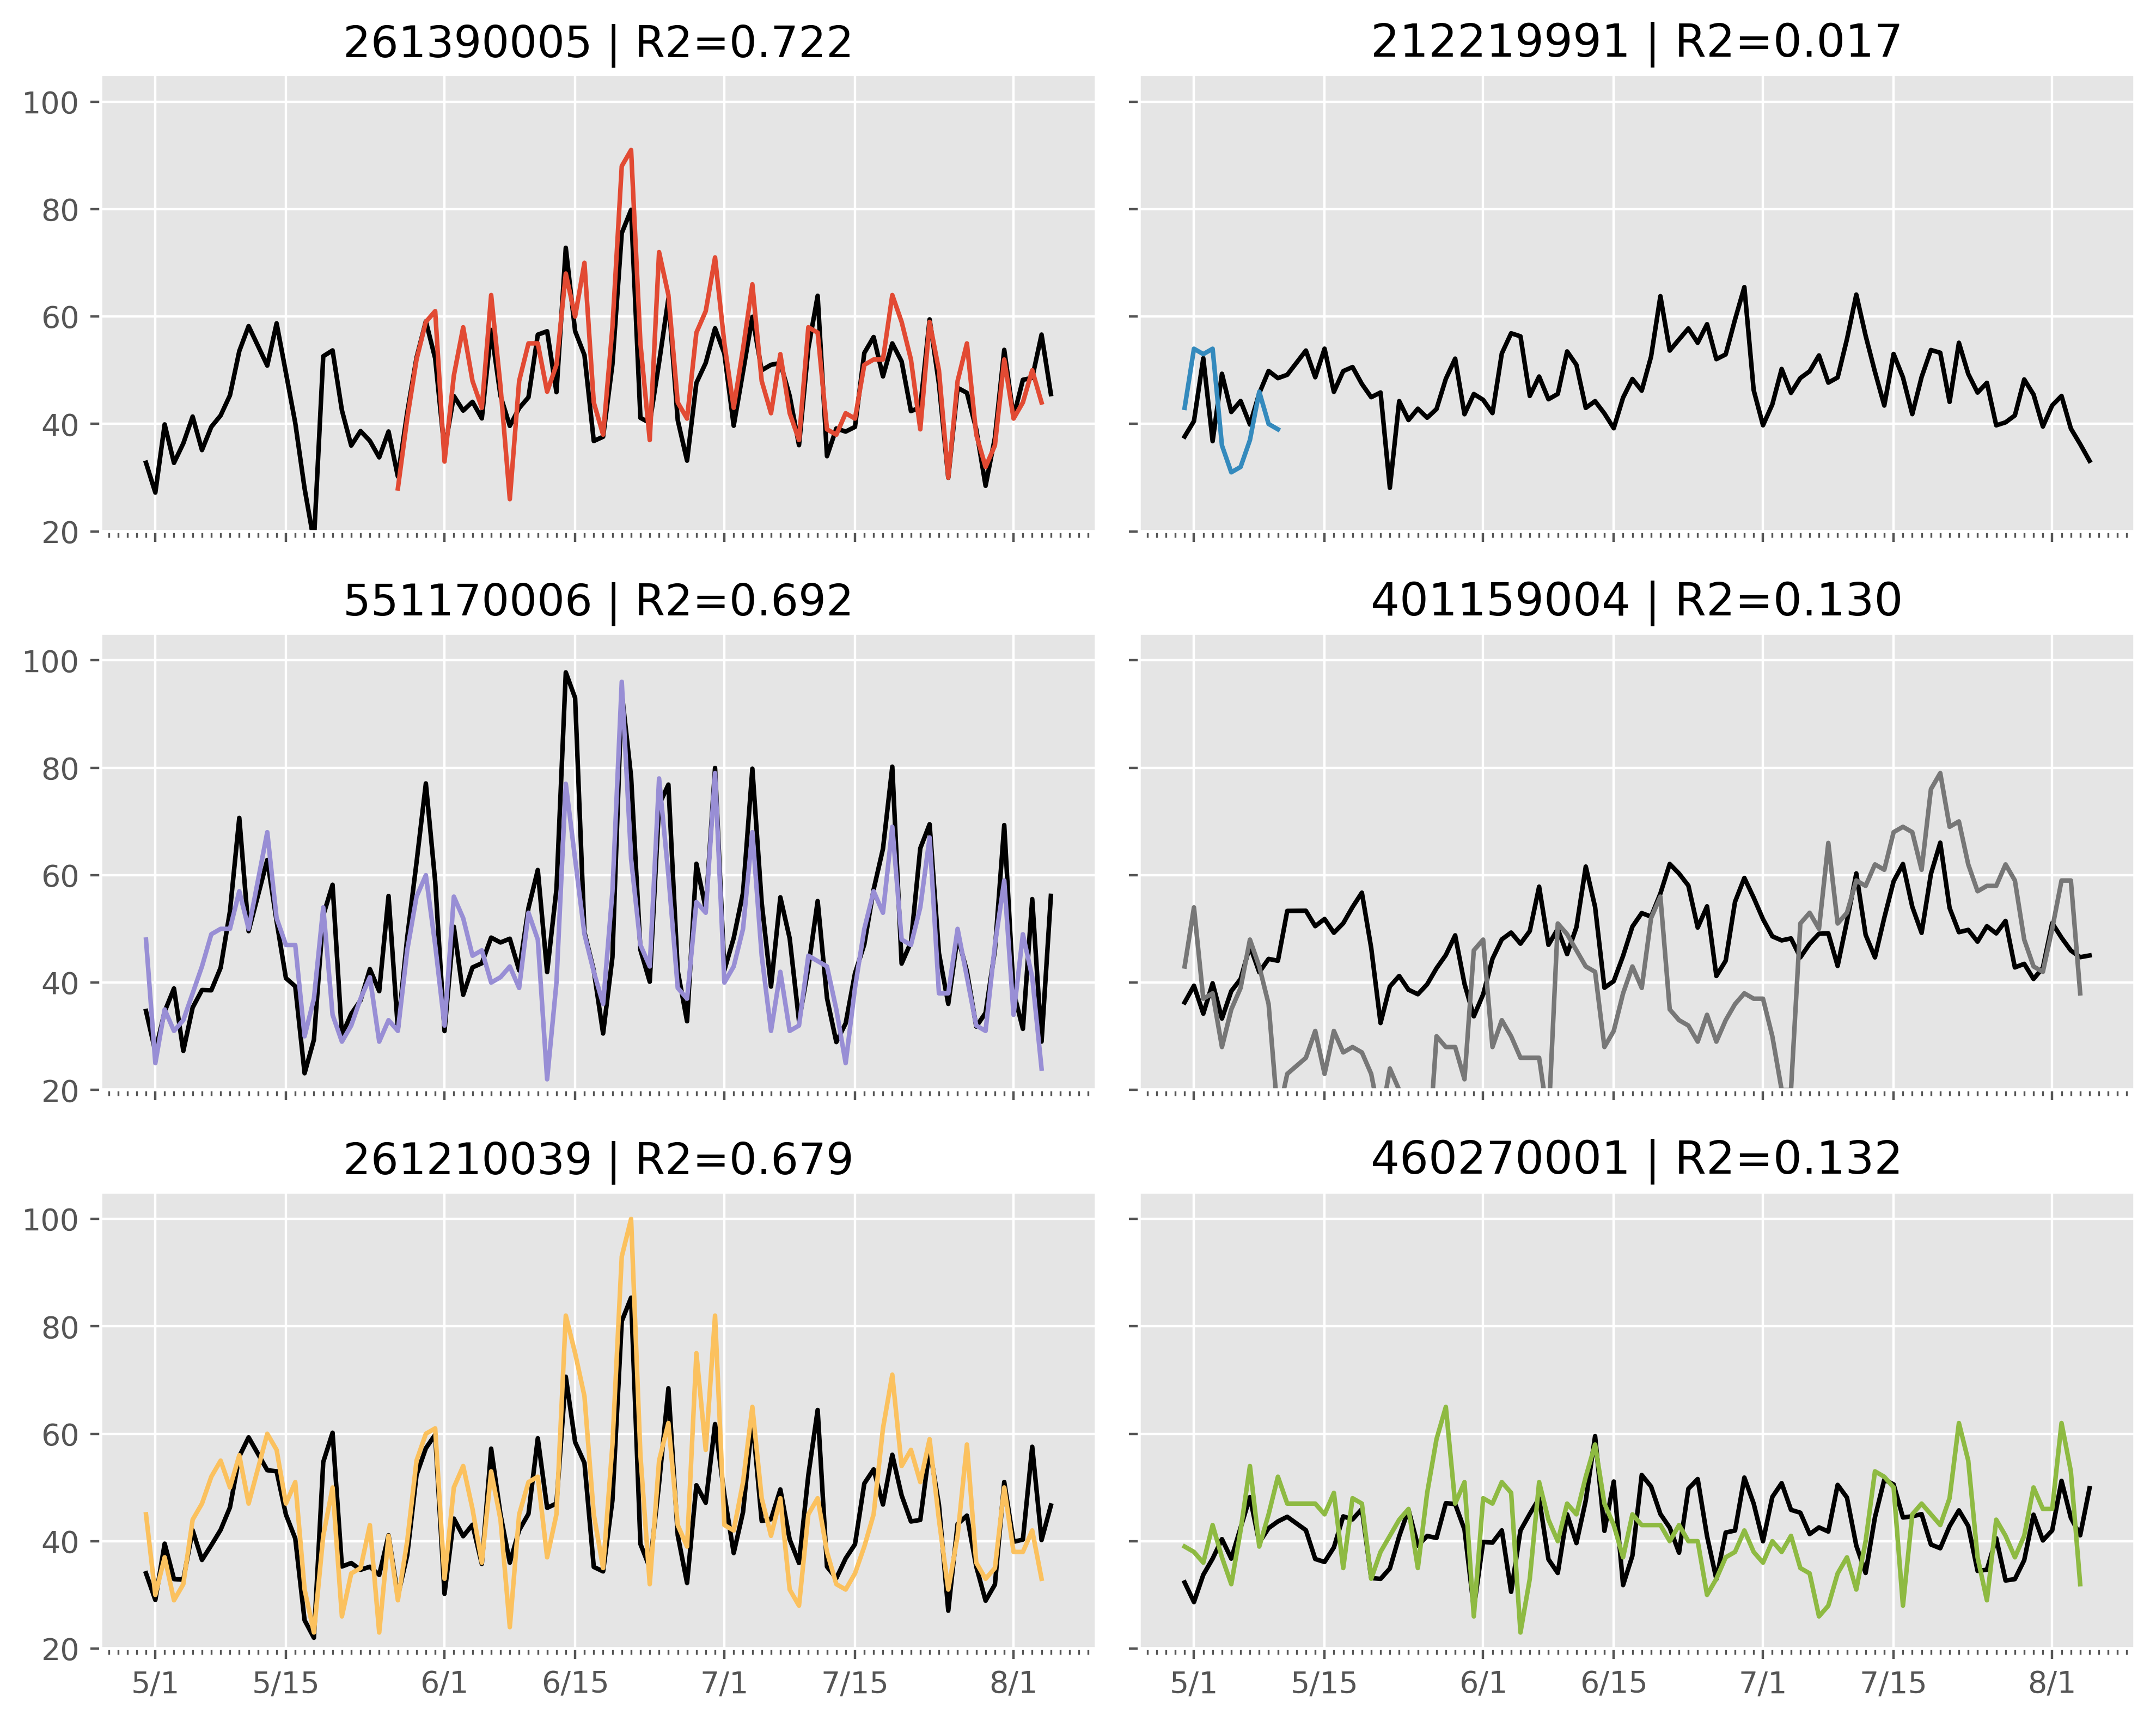

In [19]:
n_show = 3

fig, axs = plt.subplots(
    nrows=3, ncols=2, figsize=(10, 8), dpi=400, sharex=True, sharey=True, layout="tight"
)

axs = axs.flatten()

# Get the colors from the current style sheet for explicit selection within loop
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

shown_sites = []

for ix, ax in enumerate(axs[::2]):
    station = stations_rval.iloc[ix]

    data = paired_data[station.name]

    ax.plot(data.index, data["CMAQ"], color="k")
    ax.plot(data.index, data["AQS"], color=colors[2 * ix])

    ax.set_title(f"{station.name} | R2={station['R2']:.3f}")

    shown_sites.append(station.name)

for ix, ax in enumerate(axs[1::2]):
    idx = -ix - 1
    station = stations_rval.iloc[idx]

    data = paired_data[station.name]

    ax.plot(data.index, data["CMAQ"], color="k")
    ax.plot(data.index, data["AQS"], color=colors[2 * ix + 1])

    ax.set_title(f"{station.name} | R2={station['R2']:.3f}", fontsize=15)

    shown_sites.append(station.name)

ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=[1, 15]))
ax.xaxis.set_minor_locator(mpl.dates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%-m/%-d"))

ax.set_ylim(20, 105)

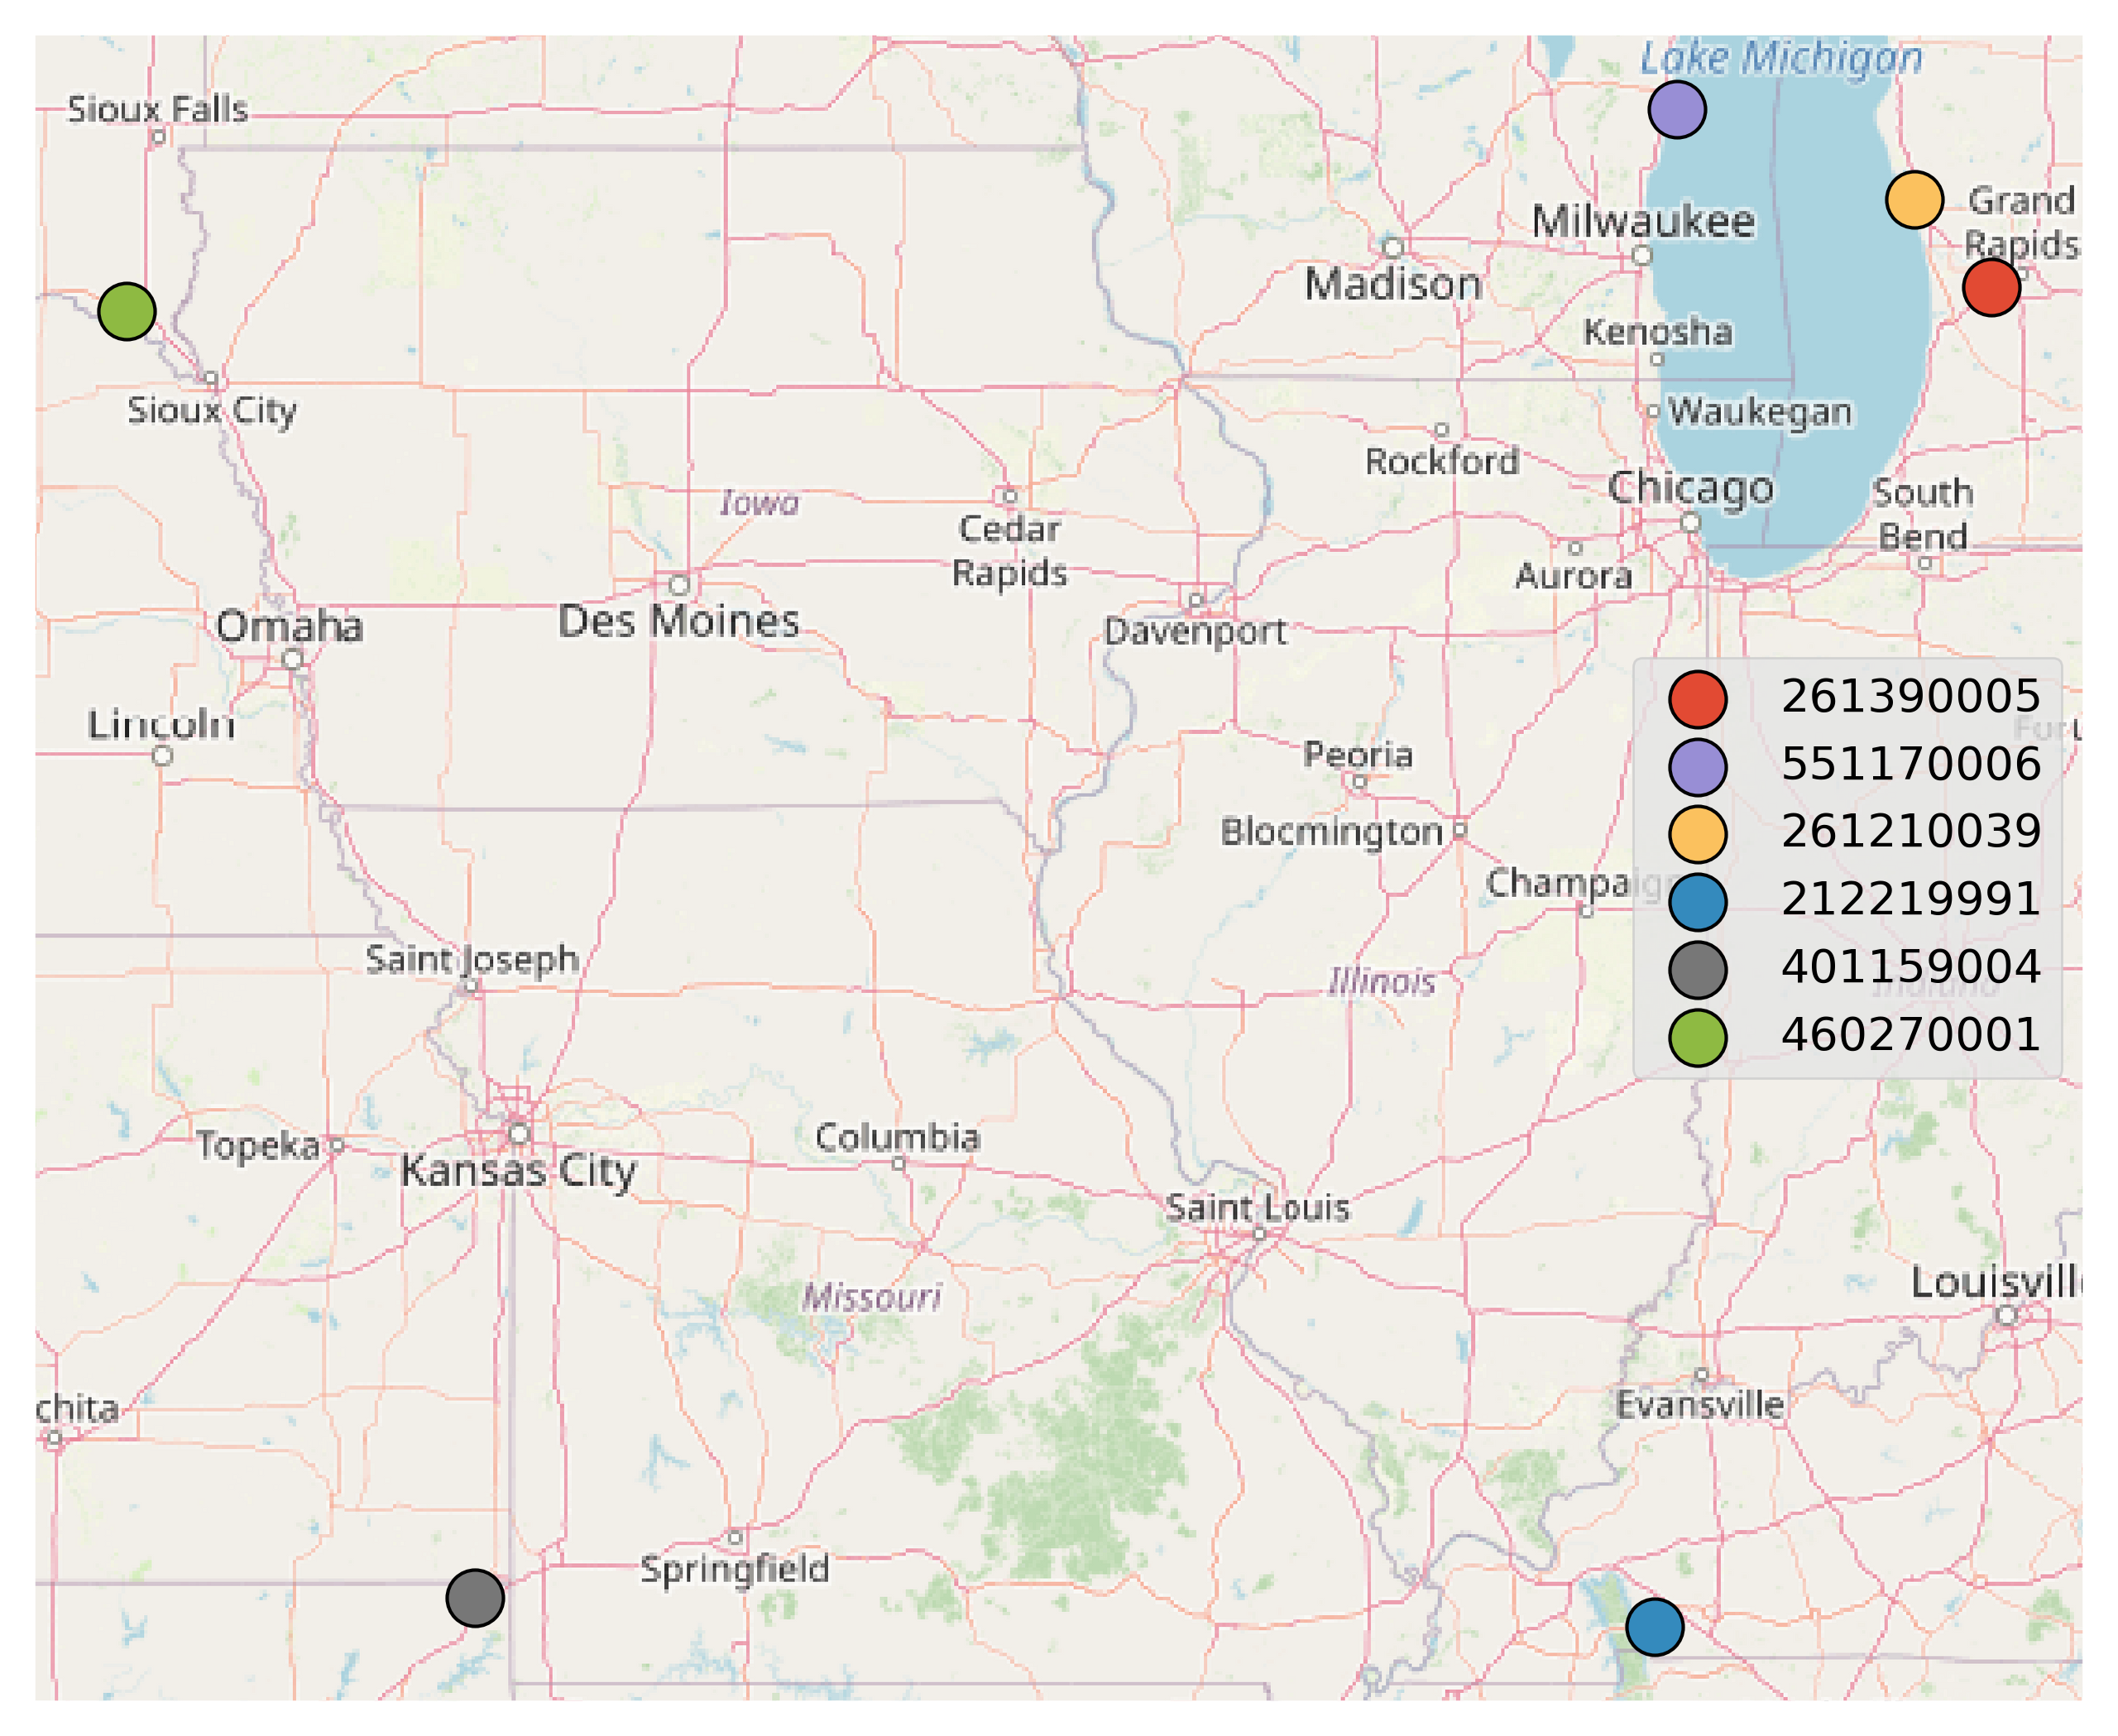

In [20]:
# Map tiles are natively in (web) mercator so using a mercator projection minimizes
# projection and interpolation issues which can make the image too fuzzy. But
# can use any desired projection.
fig_proj = ccrs.Mercator()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=fig_proj), dpi=400)

tiles = cimgt.OSM(cache=True)

for ix, station in enumerate(shown_sites[:3]):
    tmp = stations.loc[station]

    ax.scatter(
        tmp["geometry"].x,
        tmp["geometry"].y,
        color=colors[2 * ix],
        ec="k",
        lw=0.75,
        label=tmp.name,
        s=150,
        transform=ccrs.PlateCarree(),
        zorder=11,
    )

for ix, station in enumerate(shown_sites[3:]):
    tmp = stations.loc[station]

    ax.scatter(
        tmp["geometry"].x,
        tmp["geometry"].y,
        color=colors[2 * ix + 1],
        ec="k",
        lw=0.75,
        label=tmp.name,
        s=150,
        transform=ccrs.PlateCarree(),
        zorder=11,
    )

map_tiles(ax, zoom=6)

ax.legend()